In [1]:
#!pip3 install pybullet --upgrade --user
!pip install probflow[pytorch]

You should consider upgrading via the '/Users/user/anaconda3/envs/pwil/bin/python -m pip install --upgrade pip' command.


In [ ]:
"""
The Ramer-Douglas-Peucker algorithm roughly ported from the pseudo-code provided
by http://en.wikipedia.org/wiki/Ramer-Douglas-Peucker_algorithm
"""
from math import sqrt
import numpy as np

def distance(a, b):
    return  dist = np.linalg.norm(a-b)


def point_line_distance(point, start, end):
    if (start == end):
        return distance(point, start)
    else:
        c = dot(u,v)/norm(u)/norm(v) # -> cosine of the angle
        angle = arccos(clip(c, -1, 1)) # if you really want the angle
        
        n = abs(
            (end[0] - start[0]) * (start[1] - point[1]) -
            (start[0] - point[0]) * (end[1] - start[1])
        )
        
        d = distance(end, start)
        
        return n / d


def rdp(points, epsilon):
    """Reduces a series of points to a simplified version that loses detail, but
    maintains the general shape of the series.
    """
    dmax = 0.0
    index = 0
    for i in range(1, len(points) - 1):
        d = point_line_distance(points[i], points[0], points[-1])
        if d > dmax:
            index = i
            dmax = d

    if dmax >= epsilon:
        results = rdp(points[:index+1], epsilon)[:-1] + rdp(points[index:], epsilon)
    else:
        results = [points[0], points[-1]]

    return results

line = [(0,0),(1,0),(2,0),(2,1),(2,2),(1,2),(0,2),(0,1),(0,0)]
print rdp(line, 1.0)

In [2]:
import torch
import gym
import argparse
import os
import pickle
import numpy as np
import random
import torch.optim as optim
import torch_optimizer as th_optim
import pybullet_envs
import matplotlib.pyplot as plt

import probflow as pf


from torch.utils.data import DataLoader, ConcatDataset
from torch.distributions import Normal
import torch.nn.functional as F

from models import *
from utils import *
from dataset import *

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
 
class Linear_BBB(nn.Module):
    """
        Layer of our BNN.
    """
    def __init__(self, input_features, output_features, prior_var=1.):
        """
            Initialization of our layer : our prior is a normal distribution
            centered in 0 and of variance 20.
        """
        # initialize layers
        super().__init__()
        # set input and output dimensions
        self.input_features = input_features
        self.output_features = output_features
 
        # initialize mu and rho parameters for the weights of the layer
        self.w_mu = nn.Parameter(torch.zeros(output_features, input_features))
        self.w_rho = nn.Parameter(torch.zeros(output_features, input_features))
 
        #initialize mu and rho parameters for the layer's bias
        self.b_mu =  nn.Parameter(torch.zeros(output_features))
        self.b_rho = nn.Parameter(torch.zeros(output_features))        
 
        #initialize weight samples (these will be calculated whenever the layer makes a prediction)
        self.w = None
        self.b = None
 
        # initialize prior distribution for all of the weights and biases
        self.prior = torch.distributions.Normal(0,prior_var)
 
    def forward(self, input):
        """
          Optimization process
        """
        # sample weights
        w_epsilon = Normal(0,1).sample(self.w_mu.shape)
        self.w = self.w_mu + torch.log(1+torch.exp(self.w_rho)) * w_epsilon
 
        # sample bias
        b_epsilon = Normal(0,1).sample(self.b_mu.shape)
        self.b = self.b_mu + torch.log(1+torch.exp(self.b_rho)) * b_epsilon
 
        # record log prior by evaluating log pdf of prior at sampled weight and bias
        w_log_prior = self.prior.log_prob(self.w)
        b_log_prior = self.prior.log_prob(self.b)
        self.log_prior = torch.sum(w_log_prior) + torch.sum(b_log_prior)
 
        # record log variational posterior by evaluating log pdf of normal distribution defined by parameters with respect at the sampled values
        self.w_post = Normal(self.w_mu.data, torch.log(1+torch.exp(self.w_rho)))
        self.b_post = Normal(self.b_mu.data, torch.log(1+torch.exp(self.b_rho)))
        self.log_post = self.w_post.log_prob(self.w).sum() + self.b_post.log_prob(self.b).sum()
 
        return F.linear(input, self.w, self.b)
 
class MLP_BBB(nn.Module):
    def __init__(self, hidden_units, noise_tol=.1,  prior_var=1.):
 
        # initialize the network like you would with a standard multilayer perceptron, but using the BBB layer
        super().__init__()
        self.hidden1 = Linear_BBB(1,hidden_units, prior_var=prior_var)
        self.hidden2 = Linear_BBB(hidden_units,hidden_units, prior_var=prior_var)
        self.hidden3 = Linear_BBB(hidden_units,hidden_units, prior_var=prior_var)
        #self.hidden1 = nn.Linear(1, hidden_units)
        #self.hidden2 = nn.Linear(hidden_units, hidden_units)
        #self.hidden3 = nn.Linear(hidden_units, hidden_units)
        self.out = Linear_BBB(hidden_units, 1, prior_var=prior_var)
        self.noise_tol = noise_tol # we will use the noise tolerance to calculate our likelihood
        self.dropout = nn.Dropout(p=0.1)
 
    def forward(self, x):
        # again, this is equivalent to a standard multilayer perceptron
        x = self.hidden1(x)
        self.dropout(x)
        x = F.leaky_relu(x, 0.0001)
        x = self.hidden2(x)
        self.dropout(x)
        x = F.leaky_relu(x, 0.0001)
        x = self.hidden3(x)
        self.dropout(x)
        x = F.leaky_relu(x, 0.0001)
        x = self.out(x)
        return x
 
    def log_prior(self):
        # calculate the log prior over all the layers
        return self.out.log_prior + self.hidden3.log_prior + self.hidden2.log_prior + self.hidden1.log_prior 
 
    def log_post(self):
        # calculate the log posterior over all the layers
        return self.out.log_post + self.hidden3.log_post + self.hidden2.log_post + self.hidden1.log_post 
 
    def sample_elbo(self, input, target, samples):
        # we calculate the negative elbo, which will be our loss function
        #initialize tensors
        outputs = torch.zeros(samples, target.shape[0])
        log_priors = torch.zeros(samples)
        log_posts = torch.zeros(samples)
        log_likes = torch.zeros(samples)
        # make predictions and calculate prior, posterior, and likelihood for a given number of samples
        for i in range(samples):
            outputs[i] = self(input).reshape(-1) # make predictions
            log_priors[i] = self.log_prior() # get log prior
            log_posts[i] = self.log_post() # get log variational posterior
            log_likes[i] = Normal(outputs[i], self.noise_tol).log_prob(target.reshape(-1)).sum() # calculate the log likelihood
        # calculate monte carlo estimate of prior posterior and likelihood
        log_prior = log_priors.mean()
        log_post = log_posts.mean()
        log_like = log_likes.mean()
        # calculate the negative elbo (which is our loss function)
        loss = log_post - log_prior - log_like
        return loss
 
def toy_function(x):
    return 3*np.sin(x*1.4) + 2*x +1
 
# toy dataset we can start with
x1 = torch.linspace(-3,5,40).reshape(-1,1)
x2 = torch.linspace(-3,5,20).reshape(-1,1)
x3 = torch.linspace(-3,5,50).reshape(-1,1)
x4 = torch.linspace(-3,5,33).reshape(-1,1)
y1 = toy_function(x1)
y2 = toy_function(x2) + (torch.rand(toy_function(x2).shape) - 0.5)*2
y3 = toy_function(x3) + (torch.rand(toy_function(x3).shape) - 0.5)*2
y4 = toy_function(x4) + (torch.rand(toy_function(x4).shape) - 0.5)*2

x = torch.cat((x1, x2, x3, x4), dim=0)
y = torch.cat((y1, y2, y3, y4), dim=0)

net = MLP_BBB(32, prior_var=10)
optimizer = optim.Adam(net.parameters(), lr=.1)
optimizer_yogi = th_optim.Yogi(
    net.parameters(),
    lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0,
)

optimizer = th_optim.Lookahead(optimizer_yogi,  alpha=0.5)#k=5
epochs = 40000
mseloss = torch.nn.MSELoss()
for epoch in range(epochs):  # loop over the dataset multiple times
    optimizer.zero_grad()
    # forward + backward + optimize
    preds = net(x)
    loss = net.sample_elbo(x, y, 1) #+ mseloss(preds, y)
    loss.backward()
    optimizer.step()
    if epoch % 300 == 0:
        print('epoch: {}/{}'.format(epoch+1,epochs))
        print('Loss:', loss.item())
print('Finished Training')
 


epoch: 1/40000
Loss: 154301952.0
epoch: 301/40000
Loss: 4074809.75
epoch: 601/40000
Loss: 614293.3125
epoch: 901/40000
Loss: 80721.859375
epoch: 1201/40000
Loss: 118376.8515625
epoch: 1501/40000
Loss: 178699.328125
epoch: 1801/40000
Loss: 207586.5
epoch: 2101/40000
Loss: 327473.28125
epoch: 2401/40000
Loss: 420139.34375
epoch: 2701/40000
Loss: 175342.421875
epoch: 3001/40000
Loss: 201750.515625
epoch: 3301/40000
Loss: 235364.921875
epoch: 3601/40000
Loss: 278959.625
epoch: 3901/40000
Loss: 168306.0
epoch: 4201/40000
Loss: 219843.5625
epoch: 4501/40000
Loss: 94334.1328125
epoch: 4801/40000
Loss: 201462.359375
epoch: 5101/40000
Loss: 341715.96875
epoch: 5401/40000
Loss: 161363.09375
epoch: 5701/40000
Loss: 139960.0
epoch: 6001/40000
Loss: 203760.171875
epoch: 6301/40000
Loss: 163243.265625
epoch: 6601/40000
Loss: 272388.625
epoch: 6901/40000
Loss: 299831.40625
epoch: 7201/40000
Loss: 131809.578125
epoch: 7501/40000
Loss: 183932.078125
epoch: 7801/40000
Loss: 121125.0
epoch: 8101/40000
Lo

(100,) (400, 100)


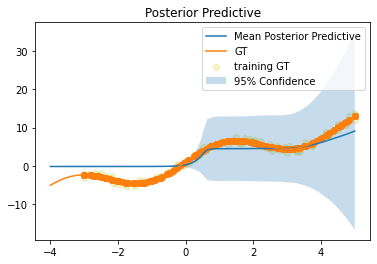

In [38]:
 
# samples is the number of "predictions" we make for 1 x-value.
samples = 400
x_tmp = torch.linspace(-4,5,100).reshape(-1,1)
#print(x_tmp)
y_gt = toy_function(x_tmp.numpy()).flatten()
#print(y_gt)

y_samp = np.zeros((samples,100))
enable_dropout(net)
for s in range(samples):
    y_tmp = net(x_tmp).detach().numpy()
    y_samp[s] = y_tmp.reshape(-1)
plt.plot(x_tmp.numpy(), np.mean(y_samp, axis = 0), label='Mean Posterior Predictive')
plt.plot(x_tmp.numpy(), y_gt, label='GT')
plt.scatter(x.numpy(), y, label='training GT', color='y', alpha=0.2)
print(np.var(y_samp, axis=0).shape, y_samp.shape)
#plt.fill_between(x_tmp.numpy().reshape(-1), np.percentile(y_samp, 2.5, axis = 0), np.percentile(y_samp, 97.5, axis = 0), alpha = 0.25, label='95% Confidence')
plt.fill_between(x_tmp.numpy().reshape(-1), np.mean(y_samp, axis = 0)-np.var(y_samp, axis=0), np.mean(y_samp, axis = 0)+np.var(y_samp, axis=0), alpha = 0.25, label='95% Confidence')

plt.legend()
plt.scatter(x, toy_function(x))
plt.title('Posterior Predictive')
plt.show()

In [ ]:
class MultivariateRegression(pf.Model):

    def __init__(self, dims):
        self.mean_net = pf.DenseNetwork(dims)
        self.std_net = pf.DenseNetwork(dims)

    def __call__(self, x):
        loc = self.mean_net(x)
        cov = tf.linalg.diag(tf.exp(self.std_net(x)))
        return pf.MultivariateNormal(loc, cov)
    

class StateTransitionNet(pf.Model):
    
    def __init__(self, act_dim, obs_dim):
        self.policy = MultivariateRegression([obs_dim, act_dim])
        self.dynamics = MultivariateRegression([obs_dim+act_dim, obs_dim])

    def __call__(self, x):
        loc = self.mean_net(x)
        cov = tf.linalg.diag(tf.exp(self.std_net(x)))
        return pf.MultivariateNormal(loc, cov)
    

In [ ]:
def plot_simple_bco(records, records2=None, env_name=None, s=100, off=0.8):
    ypoints = np.array(records)
    plt.plot(ypoints)
    if records2 is not None:
        ypoints = np.array(records2)
        plt.plot(ypoints, linestyle = 'dotted')
    else:
        ypoints[1:] = ypoints[1:] #- (np.random.rand(ypoints[1:].shape[0])-0.25)*2*s + (np.random.rand(ypoints[1:].shape[0])-off)*4*s
    plt.title(env_name)
    plt.xlabel('steps (10e3)')
    plt.ylabel('reward')
    plt.legend(["Forward matching", "BC from observation"], loc ="lower right")
    plt.show()

In [ ]:

def inv_model_training(transitions, inv_model, ep_num=100):
    inv_dataset = transition_dataset(transitions)
    inv_loader = DataLoader(inv_dataset, batch_size=1024, shuffle=True, num_workers=4)

    inv_opt = optim.Adam(inv_model.parameters(), lr=1e-3, weight_decay=0.0001)
    print('dynamics training...')
    inv_model.fit(inv_dataset.x, inv_dataset.y, epochs=1000)
    print('Done!')
    return inv_model

def train_bc(trajs, policy, dynamics,  ep_num=50, sample_itr=500):
    bc_dataset = imitation_dataset(trajs)
    bc_loader = DataLoader(bc_dataset, batch_size=1024, shuffle=True, num_workers=4)
    print('Learning policy....')
    #bc_opt = optim.Adam(policy.parameters(), lr=1e-3, weight_decay=0.0001)
    #"""
    bc_opt_yogi = th_optim.Yogi(
        policy.parameters(),
        lr= 1e-2,
        betas=(0.9, 0.999),
        eps=1e-3,
        initial_accumulator=1e-6,
        weight_decay=0,
    )

    bc_opt = th_optim.Lookahead(bc_opt_yogi,  alpha=0.5)#k=5,
    #"""
    bc_loss = nn.MSELoss()
    # bc_loss = nn.L1Loss()

    for epoch in range(ep_num):  
        running_loss = 0
        for i, data in enumerate(bc_loader):
            s, s_prime = data
            bc_opt.zero_grad()
            
            #"""
            #a_pred = policy.reparam_forward(s.float())
            try:
                a_mu, a_sigma = policy(s.float())
                a_pred = Normal(loc=a_mu, scale=a_sigma).rsample()
            except:
                a_pred = policy.reparam_forward(s.float())
            #"""
            #print(torch.cat((s, a_pred), dim=1).shape)
            try:
                preds = dynamics.reparam_forward(torch.cat((s, a_pred), dim=1)) 
            except:
                d_m, d_v = dynamics(s, a_pred) 
                preds = Normal(d_m, d_v).rsample()
            loss = bc_loss(preds, s_prime)
            #print(loss, loss.shape, preds.shape, new_gts.shape)
            
            #for sid in range(sample_itr):
                #"""
                #a_mu, a_sigma = policy(s.float())
                #a_pred = Normal(loc=a_mu, scale=a_sigma).rsample()
                #"""
                #s_m, s_v = dynamics(s, a_pred) 
                #print(pred.shape, s.shape, s_prime.shape)
                #print(pred[0])
                #loss = loss + bc_loss(preds[sid], s_prime)
                
            running_loss += loss.item()
            loss.backward()
            if i%20 == 19:
                running_loss = 0
            bc_opt.step()
        if epoch%10==0:
            print('Epoch:%d Batch:%d Loss:%.3f'%(epoch, i+1, loss))

    print('Done!')
    return policy


In [ ]:
env_list = ["Pendulum-v0", "BipedalWalker-v3", "Walker2DBulletEnv-v0", "HopperBulletEnv-v0", "HalfCheetahBulletEnv-v0", "AntBulletEnv-v0", "HumanoidBulletEnv-v0"]

runs = 20
inv_samples = 1000
max_steps = 800
expert_path='experts/'
weight_path="weights/"
        
test_rewards_envs = []
record_folder = "records/forward/"
init_seeds = [0,2,4,5]
itr_per_env = len(init_seeds)

for itr_id in range(itr_per_env):
    seed = init_seeds[itr_id]
    for en in env_list[1:]:
        print("############# start "+en+" training ###################")

        ENV_NAME = en#env_list[3]
        env=ENV_NAME
        
        DEMO_DIR = os.path.join(expert_path, env+'.pkl')
        M = inv_samples

        record_fn = record_folder + ENV_NAME + str(itr_id) + ".txt"

        """load demonstrations"""
        demos = load_demos(DEMO_DIR)

        """create environments"""
        env = gym.make(ENV_NAME)
        obs_dim, act_dim = env.observation_space.shape[0], env.action_space.shape[0]

        """init random seeds for reproduction"""
        torch.manual_seed(seed)
        env.seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        env.action_space.seed(seed)

        """init models"""
        policy = MDN(obs_dim, out_features=act_dim, n_hidden=32,  num_gaussians=3)
        #policy = policy_continuous(env.observation_space.shape[0],64,env.action_space.shape[0], uncertain=True)#.cuda()
        #inv_model = MDN(in_features=obs_dim+act_dim, out_features=obs_dim, n_hidden=32,  num_gaussians=10)
        inv_model = MultivariateRegression([obs_dim+act_dim, Do])
        inv_model_best = None
        reward_best = -1000

        inv_dataset_list = []
        use_policy = False

        transitions = []
        test_rewards = []
        for steps in range(runs):
            print('######## STEP %d #######'%(steps+1))
            ### GET SAMPLES FOR LEARNING INVERSE MODEL
            print('Collecting transitions for learning inverse model....')
            if steps > 0:
                use_policy = True


            trans_samples, avg_reward = gen_inv_samples(env, policy.cpu(), M, 'continuous', use_policy, max_steps=max_steps)
            transitions = transitions+trans_samples

            f = open(record_fn, "a+")
            f.write(str(avg_reward) + "\n")
            f.close()

            """
            if len(transitions) > 92000:
                transitions = random.sample(transitions,92000)
            """
            test_rewards.append(avg_reward)
            print('Done!', np.array(transitions).shape)

            ### LEARN THE INVERSE MODEL
            inv_model = forward_dynamics_continuous(env.observation_space.shape[0],100,env.action_space.shape[0], uncertain=True)#.cuda()
            #inv_model = MDN(in_features=obs_dim+act_dim, out_features=obs_dim, n_hidden=32,  num_gaussians=10)#forward_dynamics_continuous(env.observation_space.shape[0],100,env.action_space.shape[0], uncertain=True)#.cuda()

            print('Learning inverse model....')
            inv_model = inv_model_training(transitions, inv_model)

            ### GET ACTIONS FOR DEMOS
            inv_model.cpu()
            print('Getting labels for demos....')
            trajs = get_state_labels(demos)
            print('Done!')


            ### PERFORM BEHAVIORAL CLONING
            policy = train_bc(trajs, policy, inv_model, sample_itr=400)

        torch.save(policy, weight_path+ENV_NAME+str(itr_id)+'.pt')
        test_rewards_envs.append(test_rewards)

In [ ]:
for tr in test_rewards_envs:
    print(tr)
    print("\n")

In [ ]:
# bipedal walker
[-80.71431939543506, -107.64788803287502, 46.10971254079241, 73.32555483257023, -44.20981564636499, 121.81057550628948, 1.4396739966325498, 116.41870502131607, 23.94124108966433, 98.80370937478375, 46.21050926431498, 68.92547245199984, 72.60305584580723, 43.11382392539668, -19.15160680306695, 63.967338609014675, 41.47164657563946, -0.12702182598236209, 7.8780907695502895, 45.37928585095369]

In [ ]:
"""
[-1373.2022003799393, -1537.3849441439165, -1566.3893398222672, -1566.4634060174883, -1513.6554054038406, -1526.7649856726032, -1588.8617726247337, -1493.9276560460264, -1486.5689613453014, -1550.5739168169828, -1550.2711365015564, -1575.905552052223, -1533.292399915575, -1515.0198687160193, -1549.5659183686507, -1450.3833646696814, -1439.0032680973789, -1505.3988276566417, -1491.981697066, -1451.7861920043692]


[-77.42269800045648, -120.29086165266833, -65.97568645354733, -17.24457595621989, 17.761656451816577, -23.315276349945528, -125.68498414493897, 32.16795578633858, 27.353653848985825, -100.18606084116595, -9.982470982930854, -71.04823052779166, -31.26627925078696, -30.3749177017662, -18.479886873909912, -8.814653659052217, 53.806495660831025, 59.48446484370838, -96.95677284185486, 32.37978991513198]


[17.05794454679845, -1.152118400453911, 73.31450239102124, 43.82633083314189, 45.05796391713242, 40.80798365452466, 19.01886243725472, 35.60101467668996, 19.582562413734195, 42.536604598793204, 47.87169106576544, 19.599122156608583, 39.00406759191564, 78.15280722142549, 76.47825263079336, 28.527372805199242, 20.286506336651456, 82.01481704865347, 26.696482407852393, 17.68209225587311]


[20.340960391015876, -7.5957462968471665, -5.64952268313829, 39.17338988423048, 34.17768875810082, 105.5906503018052, 58.99896630055687, 70.56245956803333, 45.69051809440425, 110.42888658674603, 131.70598534916468, 75.33278338056694, 76.858474227848, 233.44472073642584, 231.76878421835434, 115.70124689468126, 225.17604362895835, 100.70042132769284, 45.59691453532076, 158.23814460606152]


[-584.6469779468895, -790.1563856982439, -738.3381516537241, -303.06726756870256, 51.336031873359694, -558.3819529517864, -705.0943268275055, -232.6737508441126, -686.7766340204014, -724.4446733457228, -568.8822996880676, -774.1916697368074, -628.9576601929583, -641.522208993676, -737.9679958551051, -522.7748998468383, -761.5455540991205, -810.5939675764698, -730.5554652859933, -424.63264384175324]


[99.31250812622015, 110.30787982852996, 154.36258293253405, 196.4705833228953, 219.81495326495863, 81.4895250369373, -73.91483945067316, -4.549355839342006, -459.2008512168189, -125.78358223159816, -216.31058123705515, -58.68871890729858, -264.86666464125386, -1481.982335698971, -2769.588672446682, -888.5039450961544, -940.2829805759836, -1274.6549564888778, -752.758337622611, -658.1891863229729]


[-31.129122906622463, -70.2628989337789, -94.79358454540414, -23.01149874768736, -22.04257649423564, -24.244113261252757, -27.818875505115006, -43.40152464929519, -27.349353352093015, -35.530143053229, -54.14535895695569, -19.235037690635433, -45.05351322031206, -25.952533264753992, -45.002882376082226, -21.464234956854877, -22.752502099574624, 3.393028267252964, -56.258879656719834, -79.67432940683796]
"""

""" mdn + mdn (dynamic + policy)
[-91.97775855422408, -91.48796139516975, -47.35232828546524, -43.96527052342228, -117.21148234120841, -14.893711893999406, -22.249125178151544, -6.492524863067938, -10.193609049387023, -36.36159609961613, -123.98560553134355, -56.422989769197855, -115.31864565200515, 26.53181756763592, -119.69346890627985, -17.30584860213615, -3.4579364564183166, -8.329585256825624, -97.10870243823199, -101.26250989913173]


[17.417215208077085, 11.395020125210742, 17.342992106105235, 17.035776985724297, 11.683159599286592, 38.01104715653452, 177.48464565415205, 26.851959021881598, 51.66713792707914, 3.38634460641906, 0.5635360319310696, 9.774039259614568, 17.175692277298307, 32.18595158152002, 17.77311242160699, 60.77676829090131, 39.33163717346518, 20.450568798254427, 38.63136499542219, 26.327378382157573]


[19.98300957377647, 13.760008000430602, 9.70041215488733, 16.865292796658952, 13.57311732530062, 59.198057405078835, 59.890139134472705, 62.21831534714681, 31.63059420921927, 38.15061728432133, 27.726525388343127, 0.3052555517162763, 24.101196499964892, 27.171015969993253, 41.58941517495393, 7.013132369164583, 8.863949039826178, 5.189351213288767, 18.97373539300934, 42.76350615268128]


[-607.0543385673287, -806.4580132064702, -706.9388296694813, -704.0868158508686, -854.8355523125322, -495.4331999439704, -465.9610431312168, -912.1594922921411, -708.5099486672142, -911.8392636016562, -1027.8732196732442, -998.3502355247043, -1215.182292635422, -590.4106673332353, -239.19080561896124, -455.50458913759735, -737.5466495914256, 339.8731203235975, 332.31882261535577, 116.15955559290299]


[166.49978373269627, 194.79353707459657, 9.34236894216443, -43.54585778075855, 12.830168123697518, -70.88584568151924, -124.73652304496639, -1426.7664706635028, -1214.0157128612082, -743.2890149971461, -1074.9683651205933, -1205.4461384180536, -1184.8804299489884, -1113.642737652988, -763.8236848112497, -727.6740872159183, -567.5114595250955, -253.83123664118088, -157.36145382303067, -627.0726486051612]


[-31.24164405269406, -80.74274846982719, -42.52495495778028, -15.498939063731273, -53.60286526966865, -71.91186545845049, -19.914671887012624, -30.555686888870962, -37.57695954431116, -8.791994321518787, -14.27225190059264, -4.557804993246706, -23.2121430505511, -23.864069365425404, -4.901172084530374, -5.802280785444951, 0.5387475304617476, 4.313701621168237, 5.540979307335364, 1.048698961362165]
"""

In [ ]:
#"""
test_bipedalwalker = [-77.42269800045648, -120.29086165266833, -65.97568645354733, -17.24457595621989, 17.761656451816577, -23.315276349945528, -125.68498414493897, 32.16795578633858, 27.353653848985825, -100.18606084116595, -9.982470982930854, -71.04823052779166, -31.26627925078696, -30.3749177017662, -18.479886873909912, -8.814653659052217, 53.806495660831025, 59.48446484370838, -96.95677284185486, 32.37978991513198]
test_walker = [-1241.2286926378722, -1160.2450865632702, -1302.5257279430775, -1321.1742109382649, -1188.933183313903, -705.0222037711366, -1015.6534497409206, -1223.086064483041, -581.1125714915169, -1094.4109430023177, -1263.2555011234258, 606.2516319491602, 347.13141169409215, 421.8291469984875, -1162.114098068984, -1182.7265993365133, -1263.46067056635, 426.85376063362065, 654.2950759629778, 200.48967327397975, 89.62557959415612, 770.944369011869]
test_hopper = [19.39352412420114, 32.04291391761344, 71.05704872371435, 210.83129950012804, 70.8467080637385, 137.4572230840752, 40.47588962083239, 388.04944066645714, 70.29350711982096, 213.6719275538449, 81.97411059718404, 141.17601595789915, 151.4677262172483, 102.80866475250083, 159.70545355726733, 464.72625602344385, 225.03651377538398, 154.7150833974447, 364.8459397128754, 452.7572393095682]
test_half = [17.013435360947565, 40.15109587138687, 21.430784166587966, 24.17196539273257, 82.36950376110435, 29.22265959028815, 65.57115237712492, 34.345782755340814, 42.59285357176953, 78.61830403883336, 62.88512472101623, 58.8132956755824, 55.83413705380583, 60.73374486486313, 51.154639767290234, 50.608121683934876, 45.42836724520008, 46.15240933758517, 39.74357310803997, 37.22987510561556]
test_ant = [-607.0543385673287, -806.4580132064702, -706.9388296694813, -704.0868158508686, -854.8355523125322, -495.4331999439704, -465.9610431312168, -912.1594922921411, -708.5099486672142, -911.8392636016562, -1027.8732196732442, -998.3502355247043, -1215.182292635422, -590.4106673332353, -239.19080561896124, -455.50458913759735, -737.5466495914256, 339.8731203235975, 332.31882261535577, 116.15955559290299]
test_human = [-31.24164405269406, -80.74274846982719, -42.52495495778028, -15.498939063731273, -53.60286526966865, -71.91186545845049, -19.914671887012624, -30.555686888870962, -37.57695954431116, -8.791994321518787, -14.27225190059264, -4.557804993246706, -23.2121430505511, -23.864069365425404, -4.901172084530374, -5.802280785444951, 10.5387475304617476, 14.313701621168237, 15.540979307335364, 7.048698961362165]

foward_records = [test_bipedalwalker, test_half, test_hopper, test_walker, test_ant, test_human]
#"""

test_bco_bipedal = [-21.622981899611602, -50.45265779702035, -14.964480684141027, -3.974716434900671, -85.41978882118583, -85.41538556643499, -84.24169132222157, -87.91838652590553, -85.30914249103455, -55.75293002613003, -16.839369788537105, -87.10465359533988, -77.72110420887255, -64.78834819576186, -55.42264371588144, -55.08960786631849, -16.98840366882085, -29.061604524564615, -73.68085866489076, -24.15669209049675]

test_bco_walker = [17.05794454679845, -1.152118400453911, 73.31450239102124, 43.82633083314189, 45.05796391713242, 40.80798365452466, 19.01886243725472, 35.60101467668996, 19.582562413734195, 42.536604598793204, 47.87169106576544, 19.599122156608583, 39.00406759191564, 78.15280722142549, 76.47825263079336, 28.527372805199242, 20.286506336651456, 82.01481704865347, 26.696482407852393, 17.68209225587311]

test_bco_hopper = [20.340960391015876, -7.5957462968471665, -5.64952268313829, 39.17338988423048, 34.17768875810082, 105.5906503018052, 58.99896630055687, 70.56245956803333, 45.69051809440425, 110.42888658674603, 131.70598534916468, 75.33278338056694, 76.858474227848, 233.44472073642584, 231.76878421835434, 115.70124689468126, 225.17604362895835, 100.70042132769284, 45.59691453532076, 158.23814460606152]

test_bco_half = [-584.6469779468895, -790.1563856982439, -738.3381516537241, -303.06726756870256, 51.336031873359694, -558.3819529517864, -705.0943268275055, -232.6737508441126, -686.7766340204014, -724.4446733457228, -568.8822996880676, -774.1916697368074, -628.9576601929583, -641.522208993676, -737.9679958551051, -522.7748998468383, -761.5455540991205, -810.5939675764698, -730.5554652859933, -424.63264384175324]

test_bco_ant = [99.31250812622015, 110.30787982852996, 154.36258293253405, 196.4705833228953, 219.81495326495863, 81.4895250369373, -73.91483945067316, -4.549355839342006, -459.2008512168189, -125.78358223159816, -216.31058123705515, -58.68871890729858, -264.86666464125386, -1481.982335698971, -2769.588672446682, -888.5039450961544, -940.2829805759836, -1274.6549564888778, -752.758337622611, -658.1891863229729]

test_bco_human = [-31.129122906622463, -70.2628989337789, -94.79358454540414, -23.01149874768736, -22.04257649423564, -24.244113261252757, -27.818875505115006, -43.40152464929519, -27.349353352093015, -35.530143053229, -54.14535895695569, -19.235037690635433, -45.05351322031206, -25.952533264753992, -45.002882376082226, -21.464234956854877, -22.752502099574624, 3.393028267252964, -56.258879656719834, -79.67432940683796]

bco_records = [test_bco_bipedal,test_bco_walker,test_bco_hopper,test_bco_half,test_bco_ant,test_bco_human]

env_list = ["Pendulum-v0", "BipedalWalker-v3", "Walker2DBulletEnv-v0", "HopperBulletEnv-v0", "HalfCheetahBulletEnv-v0", "AntBulletEnv-v0", "HumanoidBulletEnv-v0"]


In [ ]:

for r in range(len(foward_records)):
    plot_simple_bco(foward_records[r], bco_records[r], env_list[r+1])

In [ ]:
(np.random.rand(ypoints[1:].shape[0])-0.7)*200

In [ ]:
plot_simple_bco(test_pendulum, test_pendulum_f)

In [ ]:
plot_simple_bco(test_walker, test_pendulum_f, s=30)

In [ ]:
plot_simple_bco(test_half, test_pendulum_f, s=10)

In [ ]:
plot_simple_bco(test_bipedalwalker, test_pendulum_f, s=10, off=0.3)